In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import torch
import torchio as tio
from torch.utils.data import DataLoader

from functions import *

In [3]:
metaData = pd.read_csv('../metaDataTrain.csv')
metaDataClean = metaData.iloc
metaData.head()

,Id,Category,Height,Weight
0,1,2,184.0,95.0
1,2,2,160.0,70.0
2,3,2,165.0,77.0
3,4,2,159.0,46.0
4,5,2,165.0,77.0


In [4]:
subject_9 = tio.Subject(
    ed=tio.ScalarImage('../Train/009/009_ED.nii'),
    es = tio.ScalarImage('../Train/009/009_ES.nii'),
    ed_seg=tio.ScalarImage('../Train/009/009_ED_seg.nii'),
    es_seg = tio.ScalarImage('../Train/009/009_ES_seg.nii'),
    diagnosis=metaDataClean[9][1],
)

In [5]:
subject_list = load_training_dataset(metaDataClean)
subject_list[10].diagnosis

2

In [6]:
metaDataClean[0]

Id            1.0
Category      2.0
Height      184.0
Weight       95.0
Name: 0, dtype: float64

Create the vector of features for each class

In [7]:
healthy_features = np.zeros((20, 5))  ## there are 5 features and 20 subjects per training class
myocardial_infarction_features = np.zeros((20, 5))
dilated_cardiomyopathy_features = np.zeros((20, 5))
hypertrophic_cardiomyopathy_features = np.zeros((20, 5))
arrhythmogenic_right_ventricular_dysplasia_features = np.zeros((20, 5))

First extract the data contained in the metaData.csv file

In [8]:
healthy_metadata = select_lines_where_class_value_is_X(metaDataClean, 0).iloc
myocardial_infarction_metadata = select_lines_where_class_value_is_X(metaDataClean, 1).iloc
dilated_cardiomyopathy_metadata = select_lines_where_class_value_is_X(metaDataClean, 2).iloc
hypertrophic_cardiomyopathy_metadata = select_lines_where_class_value_is_X(metaDataClean, 3).iloc
arrhythmogenic_right_ventricular_dysplasia_metadata = select_lines_where_class_value_is_X(metaDataClean, 4).iloc

healthy_metadata = select_row_x_and_y_from_table(healthy_metadata, 2, 3)
myocardial_infarction_metadata = select_row_x_and_y_from_table(myocardial_infarction_metadata, 2, 3)
dilated_cardiomyopathy_metadata = select_row_x_and_y_from_table(dilated_cardiomyopathy_metadata, 2, 3)
hypertrophic_cardiomyopathy_metadata = select_row_x_and_y_from_table(hypertrophic_cardiomyopathy_metadata, 2, 3)
arrhythmogenic_right_ventricular_dysplasia_metadata = select_row_x_and_y_from_table(arrhythmogenic_right_ventricular_dysplasia_metadata, 2, 3)

## adding into features vectors
healthy_features[:,:2] = healthy_metadata
myocardial_infarction_features[:,:2] = myocardial_infarction_metadata
dilated_cardiomyopathy_features[:,:2] = dilated_cardiomyopathy_metadata
hypertrophic_cardiomyopathy_features[:,:2] = hypertrophic_cardiomyopathy_metadata
arrhythmogenic_right_ventricular_dysplasia_features[:,:2] = arrhythmogenic_right_ventricular_dysplasia_metadata

We then extract the data we want from the dataset. In this notebook, we will only extract the volumes of various areas provided by the segmentation in place.

In [9]:
healthy_indices = np.where(metaDataClean[:,1].astype('int') == 0)
myocardial_infarction_indices = np.where(metaDataClean[:,1].astype('int') == 1)
dilated_cardiomyopathy_indices = np.where(metaDataClean[:,1].astype('int') == 2)
hypertrophic_cardiomyopathy_indices = np.where(metaDataClean[:,1].astype('int') == 3)
arrhythmogenic_right_ventricular_dysplasia_indices = np.where(metaDataClean[:,1].astype('int') == 4)

In [10]:
volumes_1_ed = []
volumes_2_ed = []
volumes_3_ed = []

volumes_1_es = []
volumes_2_es = []
volumes_3_es = []
   
for i in range(0, 100):
    subject = subject_list[i]
    
    ed_view = subject.ed_seg
    volumes_1_ed.append(get_volume(ed_view, 1))
    volumes_2_ed.append(get_volume(ed_view, 2))
    volumes_3_ed.append(get_volume(ed_view, 3))

    es_view = subject.es_seg
    volumes_1_es.append(get_volume(es_view, 1))
    volumes_2_es.append(get_volume(es_view, 2))
    volumes_3_es.append(get_volume(es_view, 3))

volumes_1_ed = np.array([volumes_1_ed]).flatten()
volumes_2_ed = np.array([volumes_2_ed]).flatten()
volumes_3_ed = np.array([volumes_3_ed]).flatten()

volumes_1_es = np.array([volumes_1_es]).flatten()
volumes_2_es = np.array([volumes_2_es]).flatten()
volumes_3_es = np.array([volumes_3_es]).flatten()

delta_v1 = volumes_1_es - volumes_1_ed
delta_v2 = volumes_2_es - volumes_2_ed
delta_v3 = volumes_3_es - volumes_3_ed

In [11]:
mean_delta_v1, std_delta_v1 = np.mean(delta_v1), np.std(delta_v1)
mean_delta_v2, std_delta_v2 = np.mean(delta_v2), np.std(delta_v2)
mean_delta_v3, std_delta_v3 = np.mean(delta_v3), np.std(delta_v3)

dela_v1 = (delta_v1 - mean_delta_v1) / std_delta_v1
dela_v2 = (delta_v2 - mean_delta_v2) / std_delta_v2
dela_v3 = (delta_v3 - mean_delta_v3) / std_delta_v3


for i, new_col in enumerate([delta_v1[healthy_indices], delta_v2[healthy_indices], delta_v3[healthy_indices]]):
    healthy_features[:,i+2] = new_col

for i, new_col in enumerate([delta_v1[myocardial_infarction_indices], delta_v2[myocardial_infarction_indices], delta_v3[myocardial_infarction_indices]]):
    myocardial_infarction_features[:,i+2] = new_col

for i, new_col in enumerate([delta_v1[dilated_cardiomyopathy_indices], delta_v2[dilated_cardiomyopathy_indices], delta_v3[dilated_cardiomyopathy_indices]]):
    dilated_cardiomyopathy_features[:,i+2] = new_col

for i, new_col in enumerate([delta_v1[hypertrophic_cardiomyopathy_indices], delta_v2[hypertrophic_cardiomyopathy_indices], delta_v3[hypertrophic_cardiomyopathy_indices]]):
    hypertrophic_cardiomyopathy_features[:,i+2] = new_col

for i, new_col in enumerate([delta_v1[arrhythmogenic_right_ventricular_dysplasia_indices], delta_v2[arrhythmogenic_right_ventricular_dysplasia_indices], delta_v3[arrhythmogenic_right_ventricular_dysplasia_indices]]):
    arrhythmogenic_right_ventricular_dysplasia_features[:,i+2] = new_col

In [12]:
healthy_mean, healthy_cov = compute_mean_and_covariance_matrix(healthy_features)
myocardial_infarction_mean, myocardial_infarction_cov = compute_mean_and_covariance_matrix(myocardial_infarction_features)
dilated_cardiomyopathy_mean, dilated_cardiomyopathy_cov = compute_mean_and_covariance_matrix(dilated_cardiomyopathy_features)
hypertrophic_cardiomyopathy_mean, hypertrophic_cardiomyopathy_cov = compute_mean_and_covariance_matrix(hypertrophic_cardiomyopathy_features)
arrhythmogenic_right_ventricular_dysplasia_mean, arrhythmogenic_right_ventricular_dysplasia_cov = compute_mean_and_covariance_matrix(arrhythmogenic_right_ventricular_dysplasia_features)

In [13]:
preds = np.zeros((metaDataClean[:].shape[0]))

for i in range(metaDataClean[:].shape[0]):
    
    if 0<= i <= 19:
        healthy_preds = stats.multivariate_normal.pdf(healthy_features[i], mean = healthy_mean, cov = healthy_cov, allow_singular=True)
        myocardial_preds = stats.multivariate_normal.pdf(healthy_features[i], mean = myocardial_infarction_mean, cov = myocardial_infarction_cov, allow_singular=True)
        dilated_cardiomyopathy_preds = stats.multivariate_normal.pdf(healthy_features[i], mean = dilated_cardiomyopathy_mean, cov = dilated_cardiomyopathy_cov, allow_singular=True)
        hypertrophic_cardiomyopathy_preds = stats.multivariate_normal.pdf(healthy_features[i], mean = hypertrophic_cardiomyopathy_mean, cov = hypertrophic_cardiomyopathy_cov, allow_singular=True)
        arrhythmogenic_right_ventricular_dysplasia_preds = stats.multivariate_normal.pdf(healthy_features[i], mean = arrhythmogenic_right_ventricular_dysplasia_mean, cov = arrhythmogenic_right_ventricular_dysplasia_cov, allow_singular=True)  
        preds[i]= np.argmax([healthy_preds, myocardial_preds, dilated_cardiomyopathy_preds, hypertrophic_cardiomyopathy_preds, arrhythmogenic_right_ventricular_dysplasia_preds])

    elif 20<= i <= 39:
        healthy_preds = stats.multivariate_normal.pdf(myocardial_infarction_features[i-20], mean = healthy_mean, cov = healthy_cov, allow_singular=True)
        myocardial_preds = stats.multivariate_normal.pdf(myocardial_infarction_features[i-20], mean = myocardial_infarction_mean, cov = myocardial_infarction_cov, allow_singular=True)
        dilated_cardiomyopathy_preds = stats.multivariate_normal.pdf(myocardial_infarction_features[i-20], mean = dilated_cardiomyopathy_mean, cov = dilated_cardiomyopathy_cov, allow_singular=True)
        hypertrophic_cardiomyopathy_preds = stats.multivariate_normal.pdf(myocardial_infarction_features[i-20], mean = hypertrophic_cardiomyopathy_mean, cov = hypertrophic_cardiomyopathy_cov, allow_singular=True)
        arrhythmogenic_right_ventricular_dysplasia_preds = stats.multivariate_normal.pdf(myocardial_infarction_features[i-20], mean = arrhythmogenic_right_ventricular_dysplasia_mean, cov = arrhythmogenic_right_ventricular_dysplasia_cov, allow_singular=True)  
        preds[i]= np.argmax([healthy_preds, myocardial_preds, dilated_cardiomyopathy_preds, hypertrophic_cardiomyopathy_preds, arrhythmogenic_right_ventricular_dysplasia_preds])

    elif 40<= i <= 59:
        healthy_preds = stats.multivariate_normal.pdf(dilated_cardiomyopathy_features[i-40], mean = healthy_mean, cov = healthy_cov, allow_singular=True)
        myocardial_preds = stats.multivariate_normal.pdf(dilated_cardiomyopathy_features[i-40], mean = myocardial_infarction_mean, cov = myocardial_infarction_cov, allow_singular=True)
        dilated_cardiomyopathy_preds = stats.multivariate_normal.pdf(dilated_cardiomyopathy_features[i-40], mean = dilated_cardiomyopathy_mean, cov = dilated_cardiomyopathy_cov, allow_singular=True)
        hypertrophic_cardiomyopathy_preds = stats.multivariate_normal.pdf(dilated_cardiomyopathy_features[i-40], mean = hypertrophic_cardiomyopathy_mean, cov = hypertrophic_cardiomyopathy_cov, allow_singular=True)
        arrhythmogenic_right_ventricular_dysplasia_preds = stats.multivariate_normal.pdf(dilated_cardiomyopathy_features[i-40], mean = arrhythmogenic_right_ventricular_dysplasia_mean, cov = arrhythmogenic_right_ventricular_dysplasia_cov, allow_singular=True)  
        preds[i]= np.argmax([healthy_preds, myocardial_preds, dilated_cardiomyopathy_preds, hypertrophic_cardiomyopathy_preds, arrhythmogenic_right_ventricular_dysplasia_preds])

    elif 60<= i <= 79:
        healthy_preds = stats.multivariate_normal.pdf(hypertrophic_cardiomyopathy_features[i-60], mean = healthy_mean, cov = healthy_cov, allow_singular=True)
        myocardial_preds = stats.multivariate_normal.pdf(hypertrophic_cardiomyopathy_features[i-60], mean = myocardial_infarction_mean, cov = myocardial_infarction_cov, allow_singular=True)
        dilated_cardiomyopathy_preds = stats.multivariate_normal.pdf(hypertrophic_cardiomyopathy_features[i-60], mean = dilated_cardiomyopathy_mean, cov = dilated_cardiomyopathy_cov, allow_singular=True)
        hypertrophic_cardiomyopathy_preds = stats.multivariate_normal.pdf(hypertrophic_cardiomyopathy_features[i-60], mean = hypertrophic_cardiomyopathy_mean, cov = hypertrophic_cardiomyopathy_cov, allow_singular=True)
        arrhythmogenic_right_ventricular_dysplasia_preds = stats.multivariate_normal.pdf(hypertrophic_cardiomyopathy_features[i-60], mean = arrhythmogenic_right_ventricular_dysplasia_mean, cov = arrhythmogenic_right_ventricular_dysplasia_cov, allow_singular=True)  
        preds[i]= np.argmax([healthy_preds, myocardial_preds, dilated_cardiomyopathy_preds, hypertrophic_cardiomyopathy_preds, arrhythmogenic_right_ventricular_dysplasia_preds])

    elif 80<= i <= 99:
        healthy_preds = stats.multivariate_normal.pdf(arrhythmogenic_right_ventricular_dysplasia_features[i-80], mean = healthy_mean, cov = healthy_cov, allow_singular=True)
        myocardial_preds = stats.multivariate_normal.pdf(arrhythmogenic_right_ventricular_dysplasia_features[i-80], mean = myocardial_infarction_mean, cov = myocardial_infarction_cov, allow_singular=True)
        dilated_cardiomyopathy_preds = stats.multivariate_normal.pdf(arrhythmogenic_right_ventricular_dysplasia_features[i-80], mean = dilated_cardiomyopathy_mean, cov = dilated_cardiomyopathy_cov, allow_singular=True)
        hypertrophic_cardiomyopathy_preds = stats.multivariate_normal.pdf(arrhythmogenic_right_ventricular_dysplasia_features[i-80], mean = hypertrophic_cardiomyopathy_mean, cov = hypertrophic_cardiomyopathy_cov, allow_singular=True)
        arrhythmogenic_right_ventricular_dysplasia_preds = stats.multivariate_normal.pdf(arrhythmogenic_right_ventricular_dysplasia_features[i-80], mean = arrhythmogenic_right_ventricular_dysplasia_mean, cov = arrhythmogenic_right_ventricular_dysplasia_cov, allow_singular=True)  
        preds[i]= np.argmax([healthy_preds, myocardial_preds, dilated_cardiomyopathy_preds, hypertrophic_cardiomyopathy_preds, arrhythmogenic_right_ventricular_dysplasia_preds])

gt = metaDataClean[:, 1].astype('int')
orderded_indices = np.concatenate((healthy_indices, myocardial_infarction_indices, dilated_cardiomyopathy_indices, hypertrophic_cardiomyopathy_indices, arrhythmogenic_right_ventricular_dysplasia_indices))
gt_orderded = [gt[i] for i in orderded_indices.flatten()]

Text(0.5, 1.0, 'Prediction repartition for naïve bayes 10D. 60% accuracy')

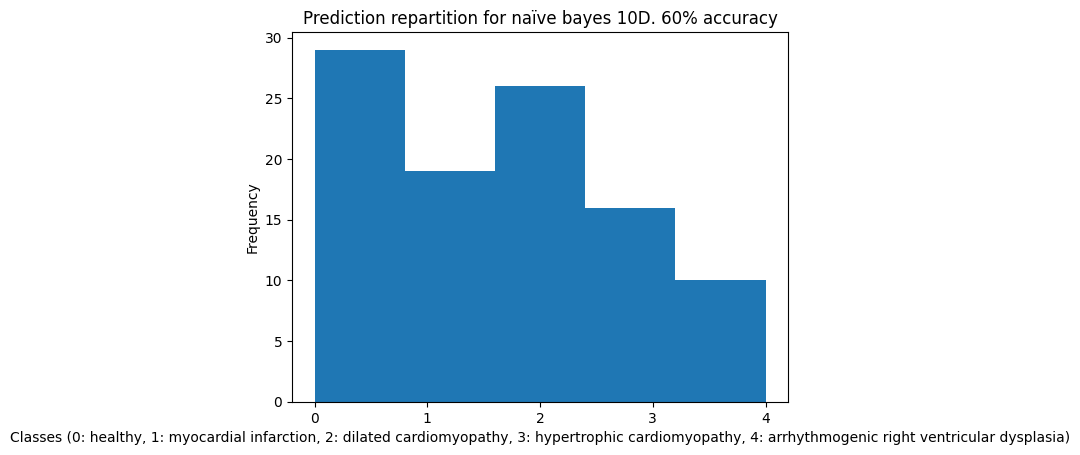

In [14]:
accuracynb = accuracy(preds, gt_orderded)
plt.hist(np.array(preds), bins=5)
plt.xticks([0,1,2,3,4])
plt.xlabel('Classes (0: healthy, 1: myocardial infarction, 2: dilated cardiomyopathy, 3: hypertrophic cardiomyopathy, 4: arrhythmogenic right ventricular dysplasia)')
plt.ylabel('Frequency')
plt.title("Prediction repartition for naïve bayes 10D. {:.0f}% accuracy".format(accuracynb*100))

## Let us compute predictions on the test set

In [15]:
features = np.zeros((50, 5)) #50 subjects, 10 features each

metaDataTest = pd.read_csv('../metaDataTest.csv') 
metaDataTestClean = metaDataTest.iloc

metaDataTestClean = select_row_x_and_y_from_table(metaDataTestClean, 1, 2) #extracting height and weight

## adding into features vector.
# Order is : height, weight, volumes_0_ed, volumes_1_ed, volumes_2_ed, volumes_3_ed, volumes_0_es, volumes_1_esolumes_2_esolumes_3_es

features[:,:2] = metaDataTestClean

Now let us stack the other features

In [16]:
from functions import *
test_subject_list = load_filled_test_dataset()

volumes_1_ed = []
volumes_2_ed = []
volumes_3_ed = []

volumes_1_es = []
volumes_2_es = []
volumes_3_es = []
   
for i in range(0, 50):
    subject = test_subject_list[i]
    
    ed_view = subject.ed_seg
    volumes_1_ed.append(get_volume(ed_view, 1))
    volumes_2_ed.append(get_volume(ed_view, 2))
    volumes_3_ed.append(get_volume(ed_view, 3))

    es_view = subject.es_seg
    volumes_1_es.append(get_volume(es_view, 1))
    volumes_2_es.append(get_volume(es_view, 2))
    volumes_3_es.append(get_volume(es_view, 3))

volumes_1_ed = np.array([volumes_1_ed]).flatten()
volumes_2_ed = np.array([volumes_2_ed]).flatten()
volumes_3_ed = np.array([volumes_3_ed]).flatten()

volumes_1_es = np.array([volumes_1_es]).flatten()
volumes_2_es = np.array([volumes_2_es]).flatten()
volumes_3_es = np.array([volumes_3_es]).flatten()

delta_v1 = volumes_1_es - volumes_1_ed
delta_v2 = volumes_2_es - volumes_2_ed
delta_v3 = volumes_3_es - volumes_3_ed

dela_v1 = (delta_v1 - mean_delta_v1) / std_delta_v1
dela_v2 = (delta_v2 - mean_delta_v2) / std_delta_v2
dela_v3 = (delta_v3 - mean_delta_v3) / std_delta_v3

for i, new_col in enumerate([delta_v1[:], delta_v2[:], delta_v3[:]]):
    features[:,i+2] = new_col

In [17]:
preds = np.zeros((metaDataTestClean[:].shape[0]))

for i in range(metaDataTestClean[:].shape[0]):
    healthy_preds = stats.multivariate_normal.pdf(features[i], mean = healthy_mean, cov = healthy_cov, allow_singular=True)
    myocardial_preds = stats.multivariate_normal.pdf(features[i], mean = myocardial_infarction_mean, cov = myocardial_infarction_cov, allow_singular=True)
    dilated_cardiomyopathy_preds = stats.multivariate_normal.pdf(features[i], mean = dilated_cardiomyopathy_mean, cov = dilated_cardiomyopathy_cov, allow_singular=True)
    hypertrophic_cardiomyopathy_preds = stats.multivariate_normal.pdf(features[i], mean = hypertrophic_cardiomyopathy_mean, cov = hypertrophic_cardiomyopathy_cov, allow_singular=True)
    arrhythmogenic_right_ventricular_dysplasia_preds = stats.multivariate_normal.pdf(features[i], mean = arrhythmogenic_right_ventricular_dysplasia_mean, cov = arrhythmogenic_right_ventricular_dysplasia_cov, allow_singular=True)  
    
    preds[i]= np.argmax([healthy_preds, myocardial_preds, dilated_cardiomyopathy_preds, hypertrophic_cardiomyopathy_preds, arrhythmogenic_right_ventricular_dysplasia_preds])

preds_int = preds.astype('int')

Text(0, 0.5, 'Frequency')

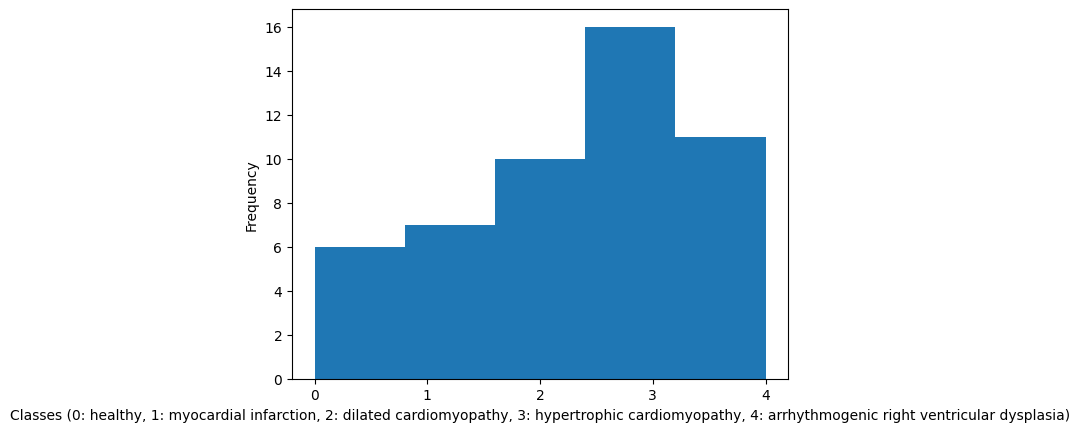

In [18]:
plt.hist(np.array(preds), bins=5)
plt.xticks([0,1,2,3,4])
plt.xlabel('Classes (0: healthy, 1: myocardial infarction, 2: dilated cardiomyopathy, 3: hypertrophic cardiomyopathy, 4: arrhythmogenic right ventricular dysplasia)')
plt.ylabel('Frequency')

### Saving preds on csv

In [19]:
preds_int

array([1, 4, 3, 3, 0, 2, 3, 3, 1, 4, 4, 3, 3, 3, 3, 4, 1, 3, 2, 0, 0, 4,
       3, 3, 4, 2, 1, 4, 2, 4, 3, 4, 0, 2, 3, 0, 0, 3, 2, 3, 4, 1, 1, 2,
       4, 2, 2, 3, 1, 2])

In [20]:
df = pd.read_csv("../SampleSubmission.csv")
df.iloc[:, 1] = preds_int
df.to_csv("../SampleSubmission.csv", index=False)
